In [2]:
%pylab inline
import seaborn as sns;sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 19,14
sns.set_context('poster', font_scale=1.4)
import galsim as gs

Populating the interactive namespace from numpy and matplotlib


## Galaxy traces

In [3]:
cat = gs.COSMOSCatalog(use_real=False)

In [3]:
cat.getNObjects()

81520

In [4]:
galaxy = cat.makeGalaxy(1)

In [9]:
shape((galaxy.drawImage(scale=0.03)).array)

(164, 164)

In [5]:
sigmas = []
for idx in range(cat.getNObjects()):
    galaxy = cat.makeGalaxy(idx)
    try:
        img = galaxy.drawImage(scale=0.03)
        moments = gs.hsm.FindAdaptiveMom(img)
        sigmas.append(moments.moments_sigma)
    except RuntimeError:
        pass

In [6]:
import pickle
pickle.dump(sigmas, open('/global/cscratch1/sd/husni/cosmos_sigmas.p', 'wb'))

In [7]:
sigmas = np.array(sigmas)*0.03
traces = 2*sigmas**2

In [23]:
np.mean(1/sigmas[sigmas<0.5])

8.390046713507846

In [8]:
np.save('/global/cscratch1/sd/husni/cosmos_traces.npy', traces)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


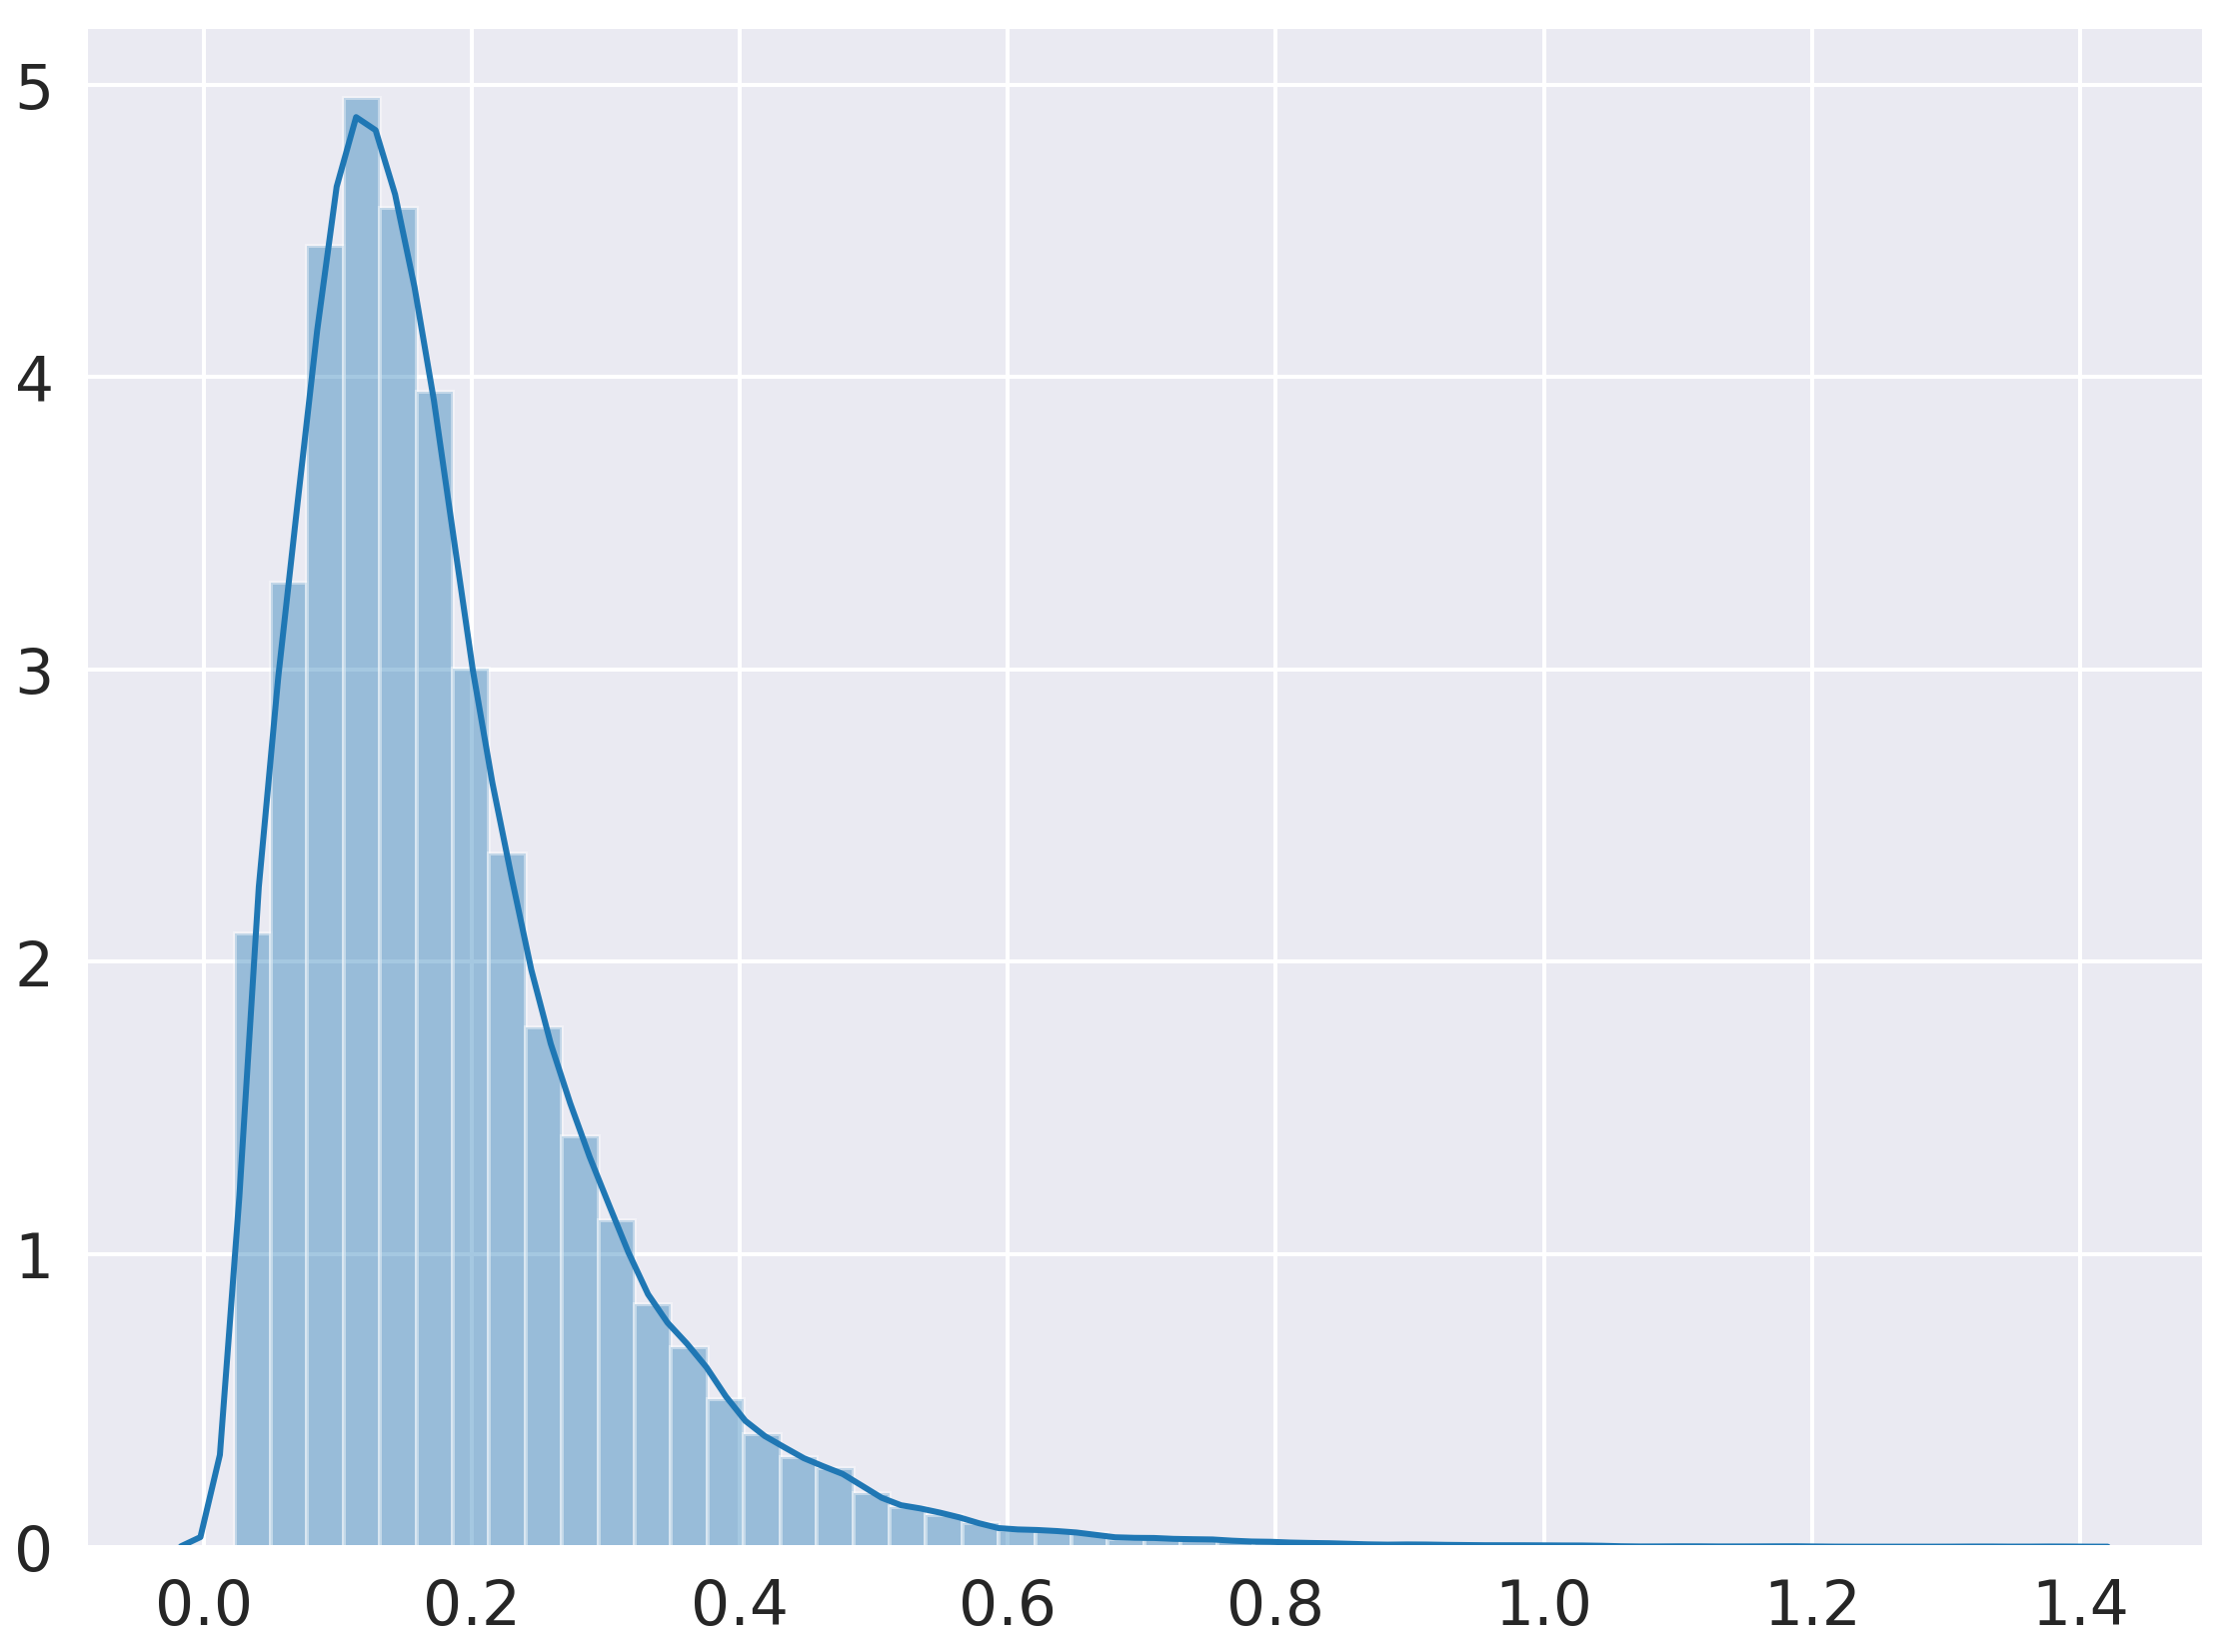

In [22]:
sns.distplot(sigmas)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0.0001, 100)

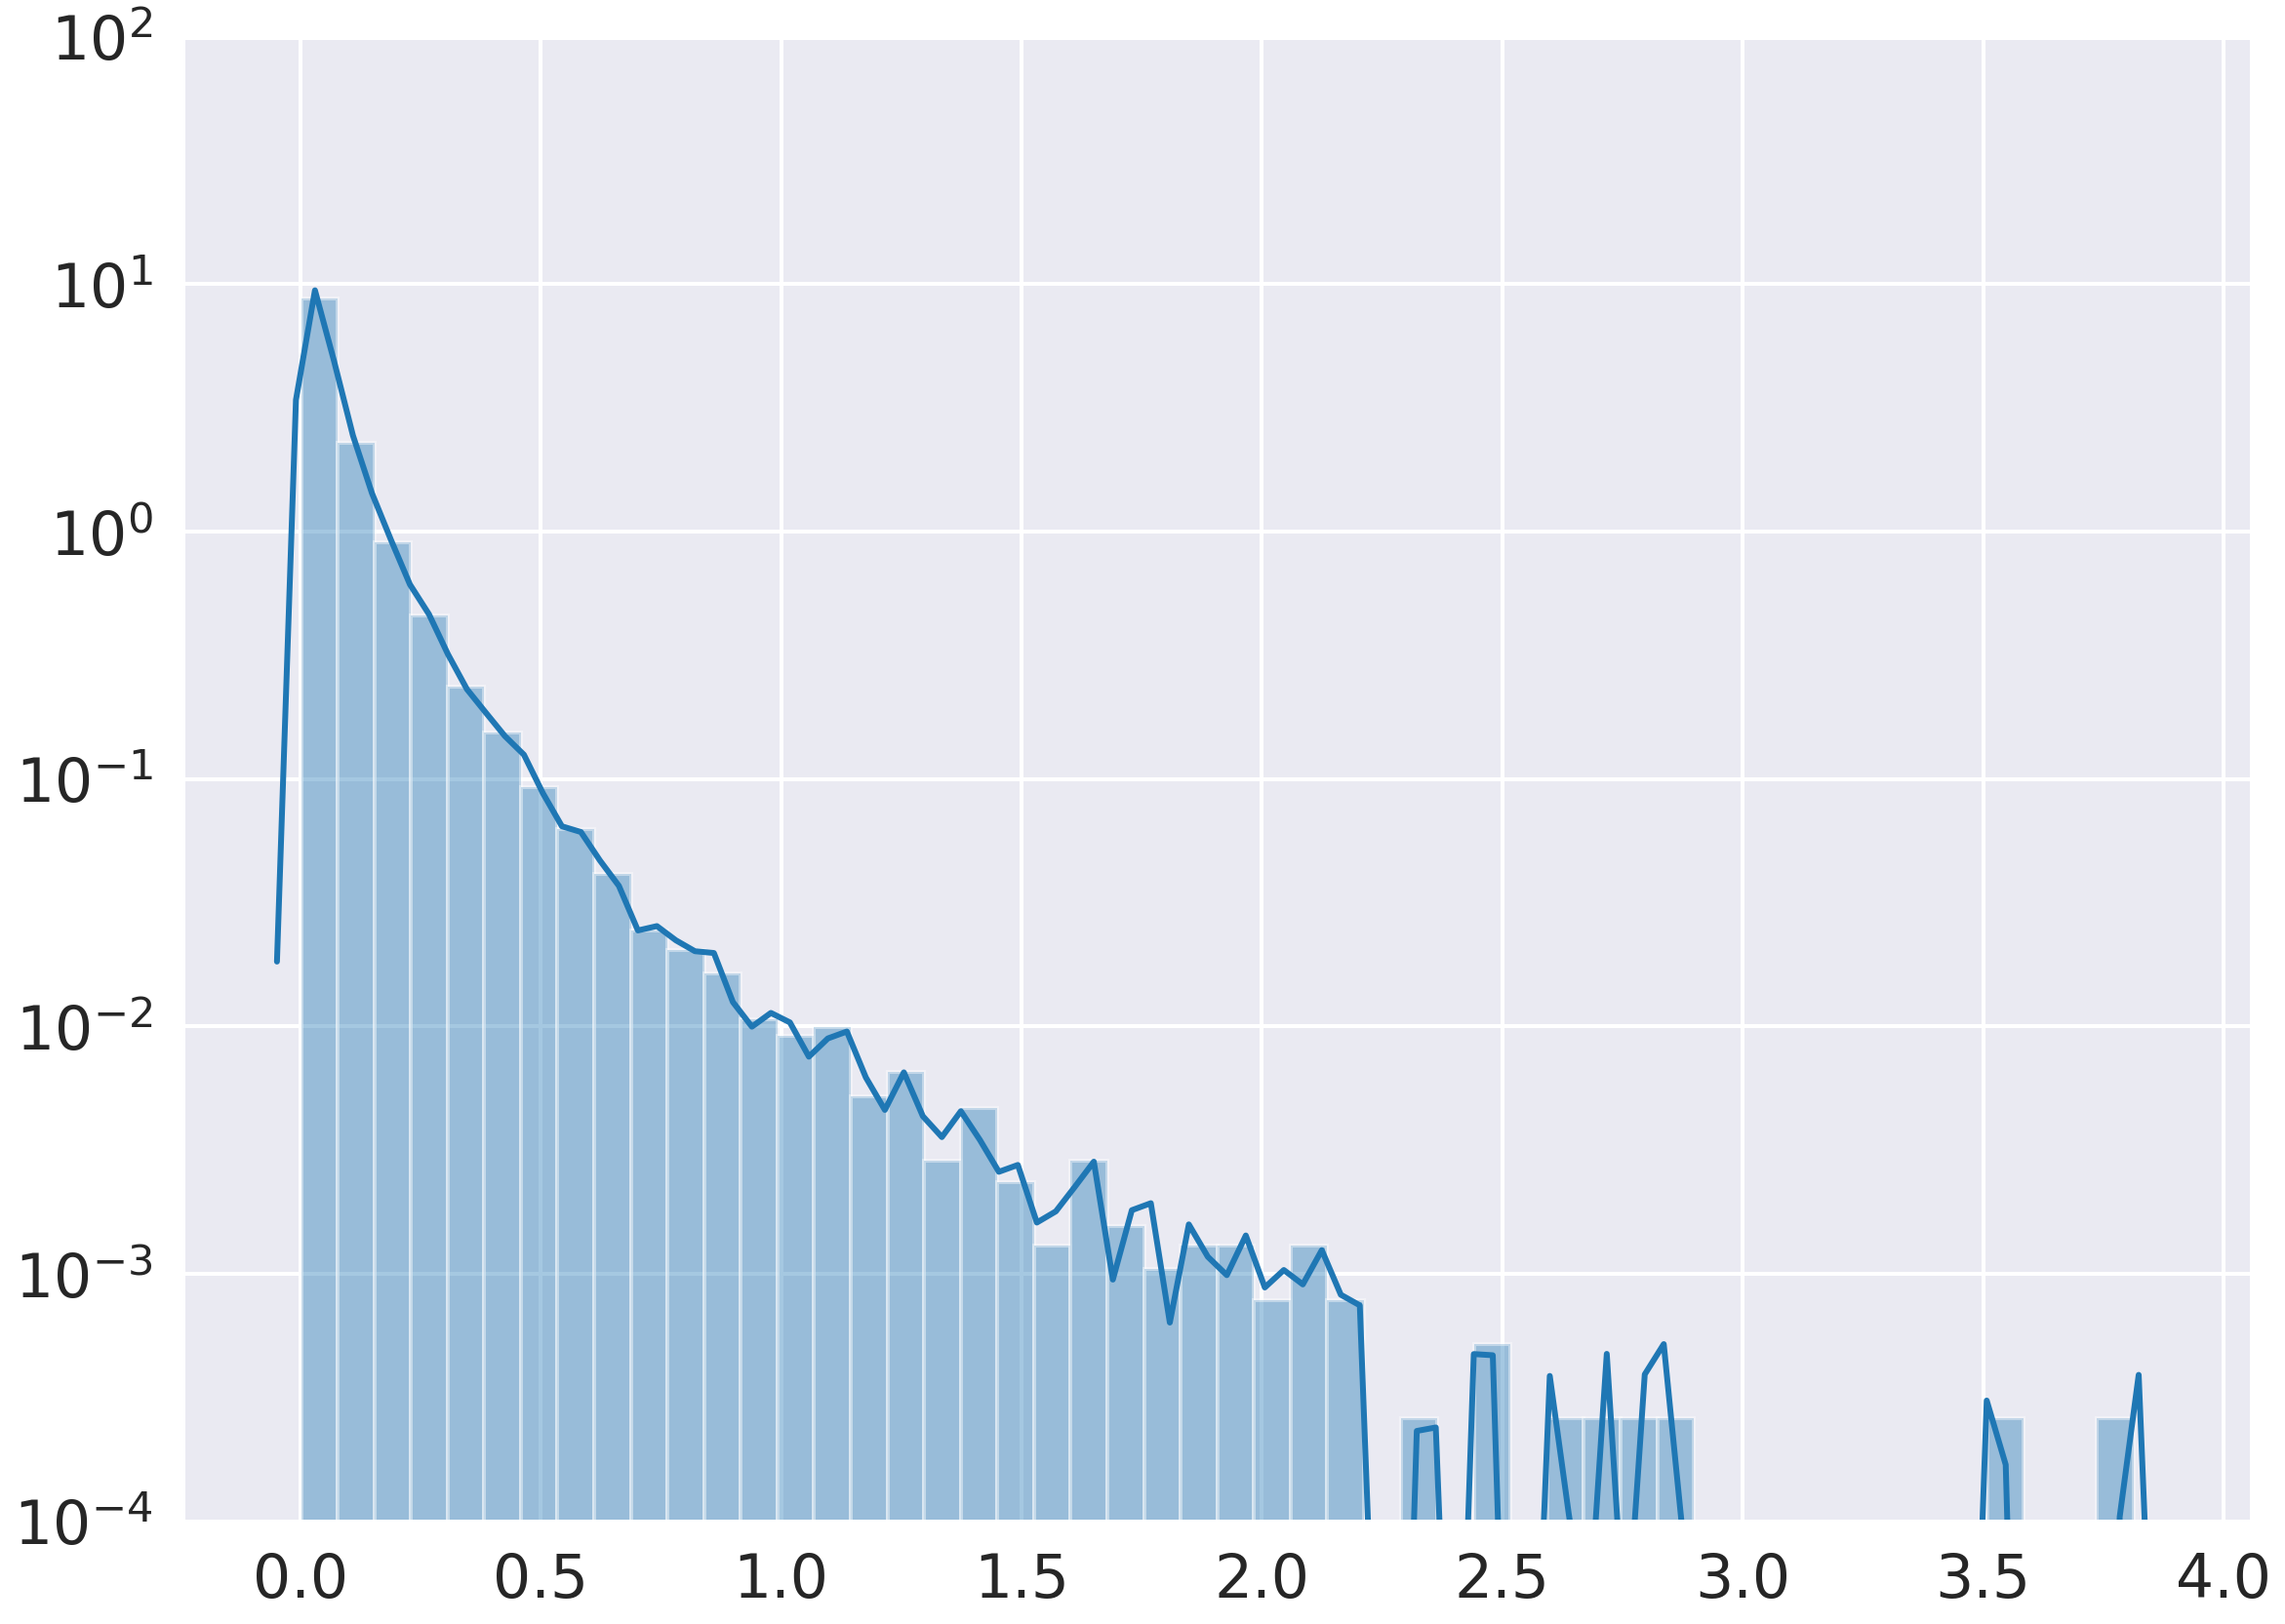

In [13]:
sns.distplot(traces)
plt.yscale('log')
plt.ylim((0.0001,100))

In [20]:
np.mean(1/traces[traces<0.01])

243.40158402467577

In [10]:
np.save('/global/cscratch1/sd/husni/cosmos_traces.npy', traces)

In [17]:
img.scale

0.03

In [18]:
len(sigmas)

50351

In [19]:
print('fraction of useable galaxies: {:.3f}'.format(len(sigmas)/cat.getNObjects()))

fraction of useable galaxies: 0.618


In [12]:
np.mean(sigmas)

0.17948332971748532

In [22]:
np.mean(1/traces)

51.83972227521563

## PSF Trace:
- Use Kolmogorov profile for several realizations of the psf simulating a distribution similar to the one in page 48 of https://docushare.lsstcorp.org/docushare/dsweb/Get/LPM-17, add 10% to the size, draw them with some small pizel scale (0.02) and get moments and invert pixel scale.
- Use number from documentation. 

In [23]:
seeings = []
for i in range(10000):
    seeings.append(np.random.lognormal(mean=-0.5104, sigma=0.452)*1.1)

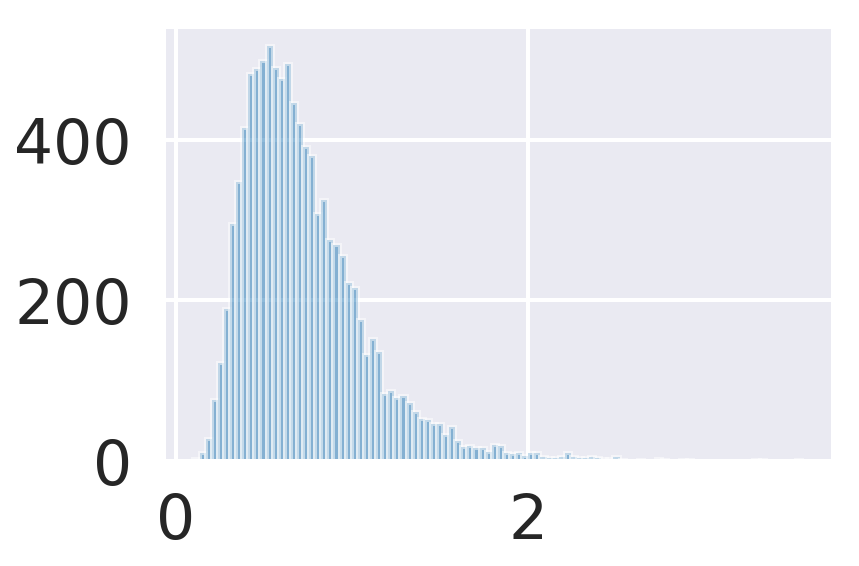

In [24]:
plt.hist(seeings, bins=100, alpha=0.5);

`seeings` is in units of FWHM, turn into units of standard deviations by drawing them as a Kolmogorov profile with small pixel-scale and then calculating the second moments, and then we can get the trace from $T = 2\sigma^2$ 

In [25]:
pixel_scale = 0.02
psf_sigmas = []
for fwhm in seeings:
    kol_profile = gs.Kolmogorov(fwhm=fwhm)
    img = kol_profile.drawImage(scale=pixel_scale)
    moms = gs.hsm.FindAdaptiveMom(img)
    psf_sigmas.append(moms.moments_sigma)

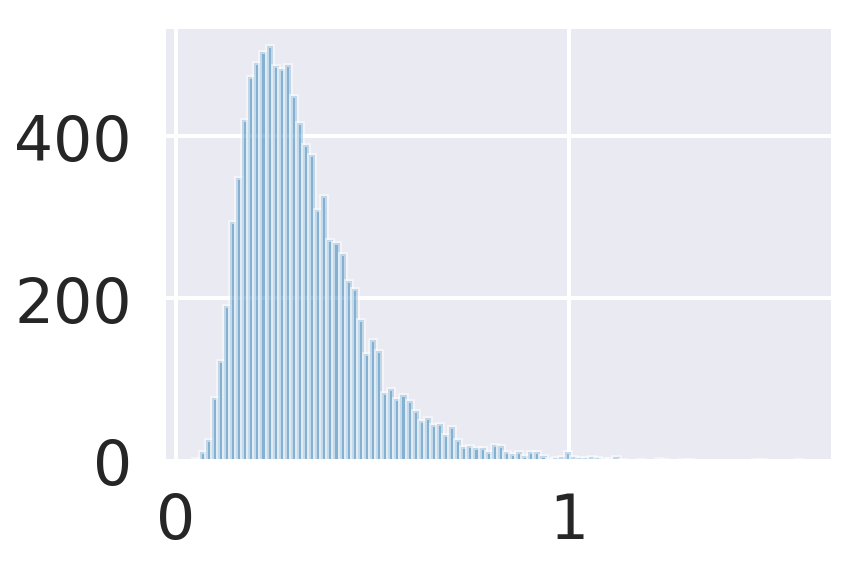

In [26]:
plt.hist(np.array(psf_sigmas)*0.02, bins=100, alpha=0.5);

In [28]:
seeings_traces = 2*(np.array(psf_sigmas)*pixel_scale)**2

In [27]:
np.mean(psf_sigmas)*pixel_scale

0.32743942725181585

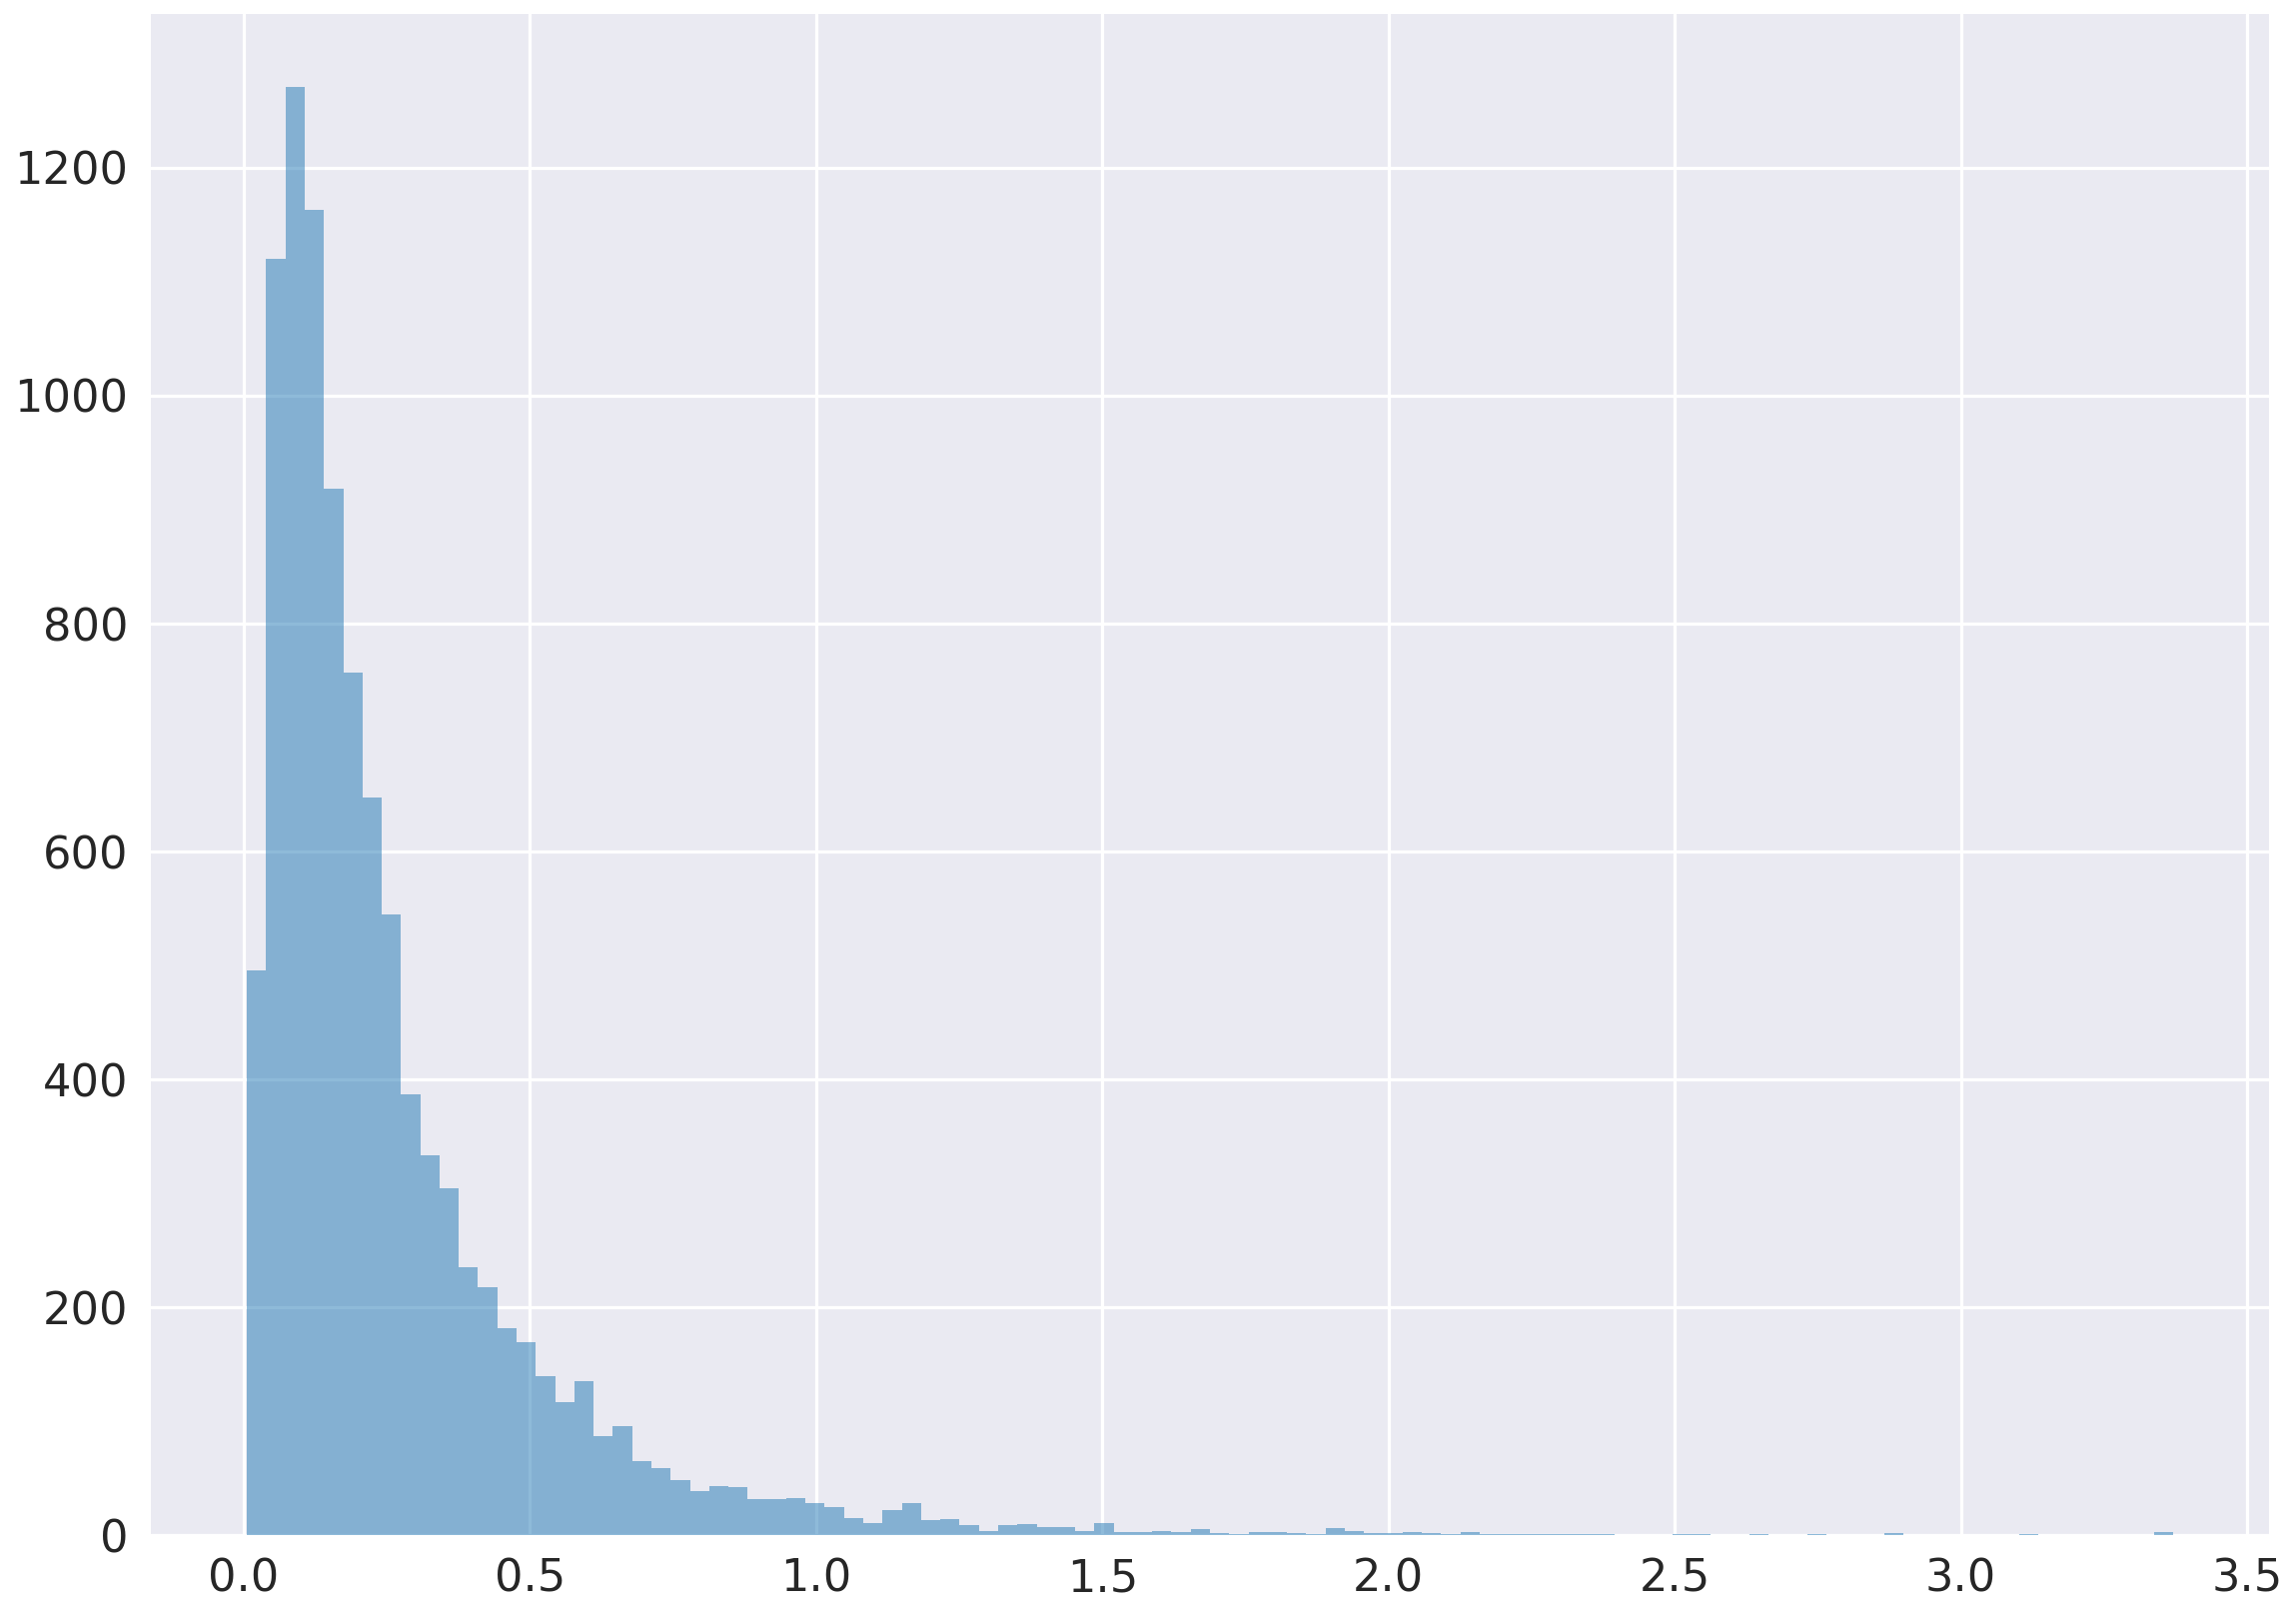

In [33]:
plt.hist(seeings_traces,bins=100, alpha=0.5);

In [29]:
np.mean(seeings_traces)

0.26318115801295283

In [30]:
51.83972227521563*0.26318115801295283

13.643238139461115

In [12]:
np.mean(ratios)

3.25430197648318

In [10]:
np.mean(np.sqrt(np.array(ratios)/2))

1.0728515136958219

In [27]:
np.save('trace_ratios.npy', np.array(ratios))

In [11]:
1.07**2*2

2.2898

(0, 1)

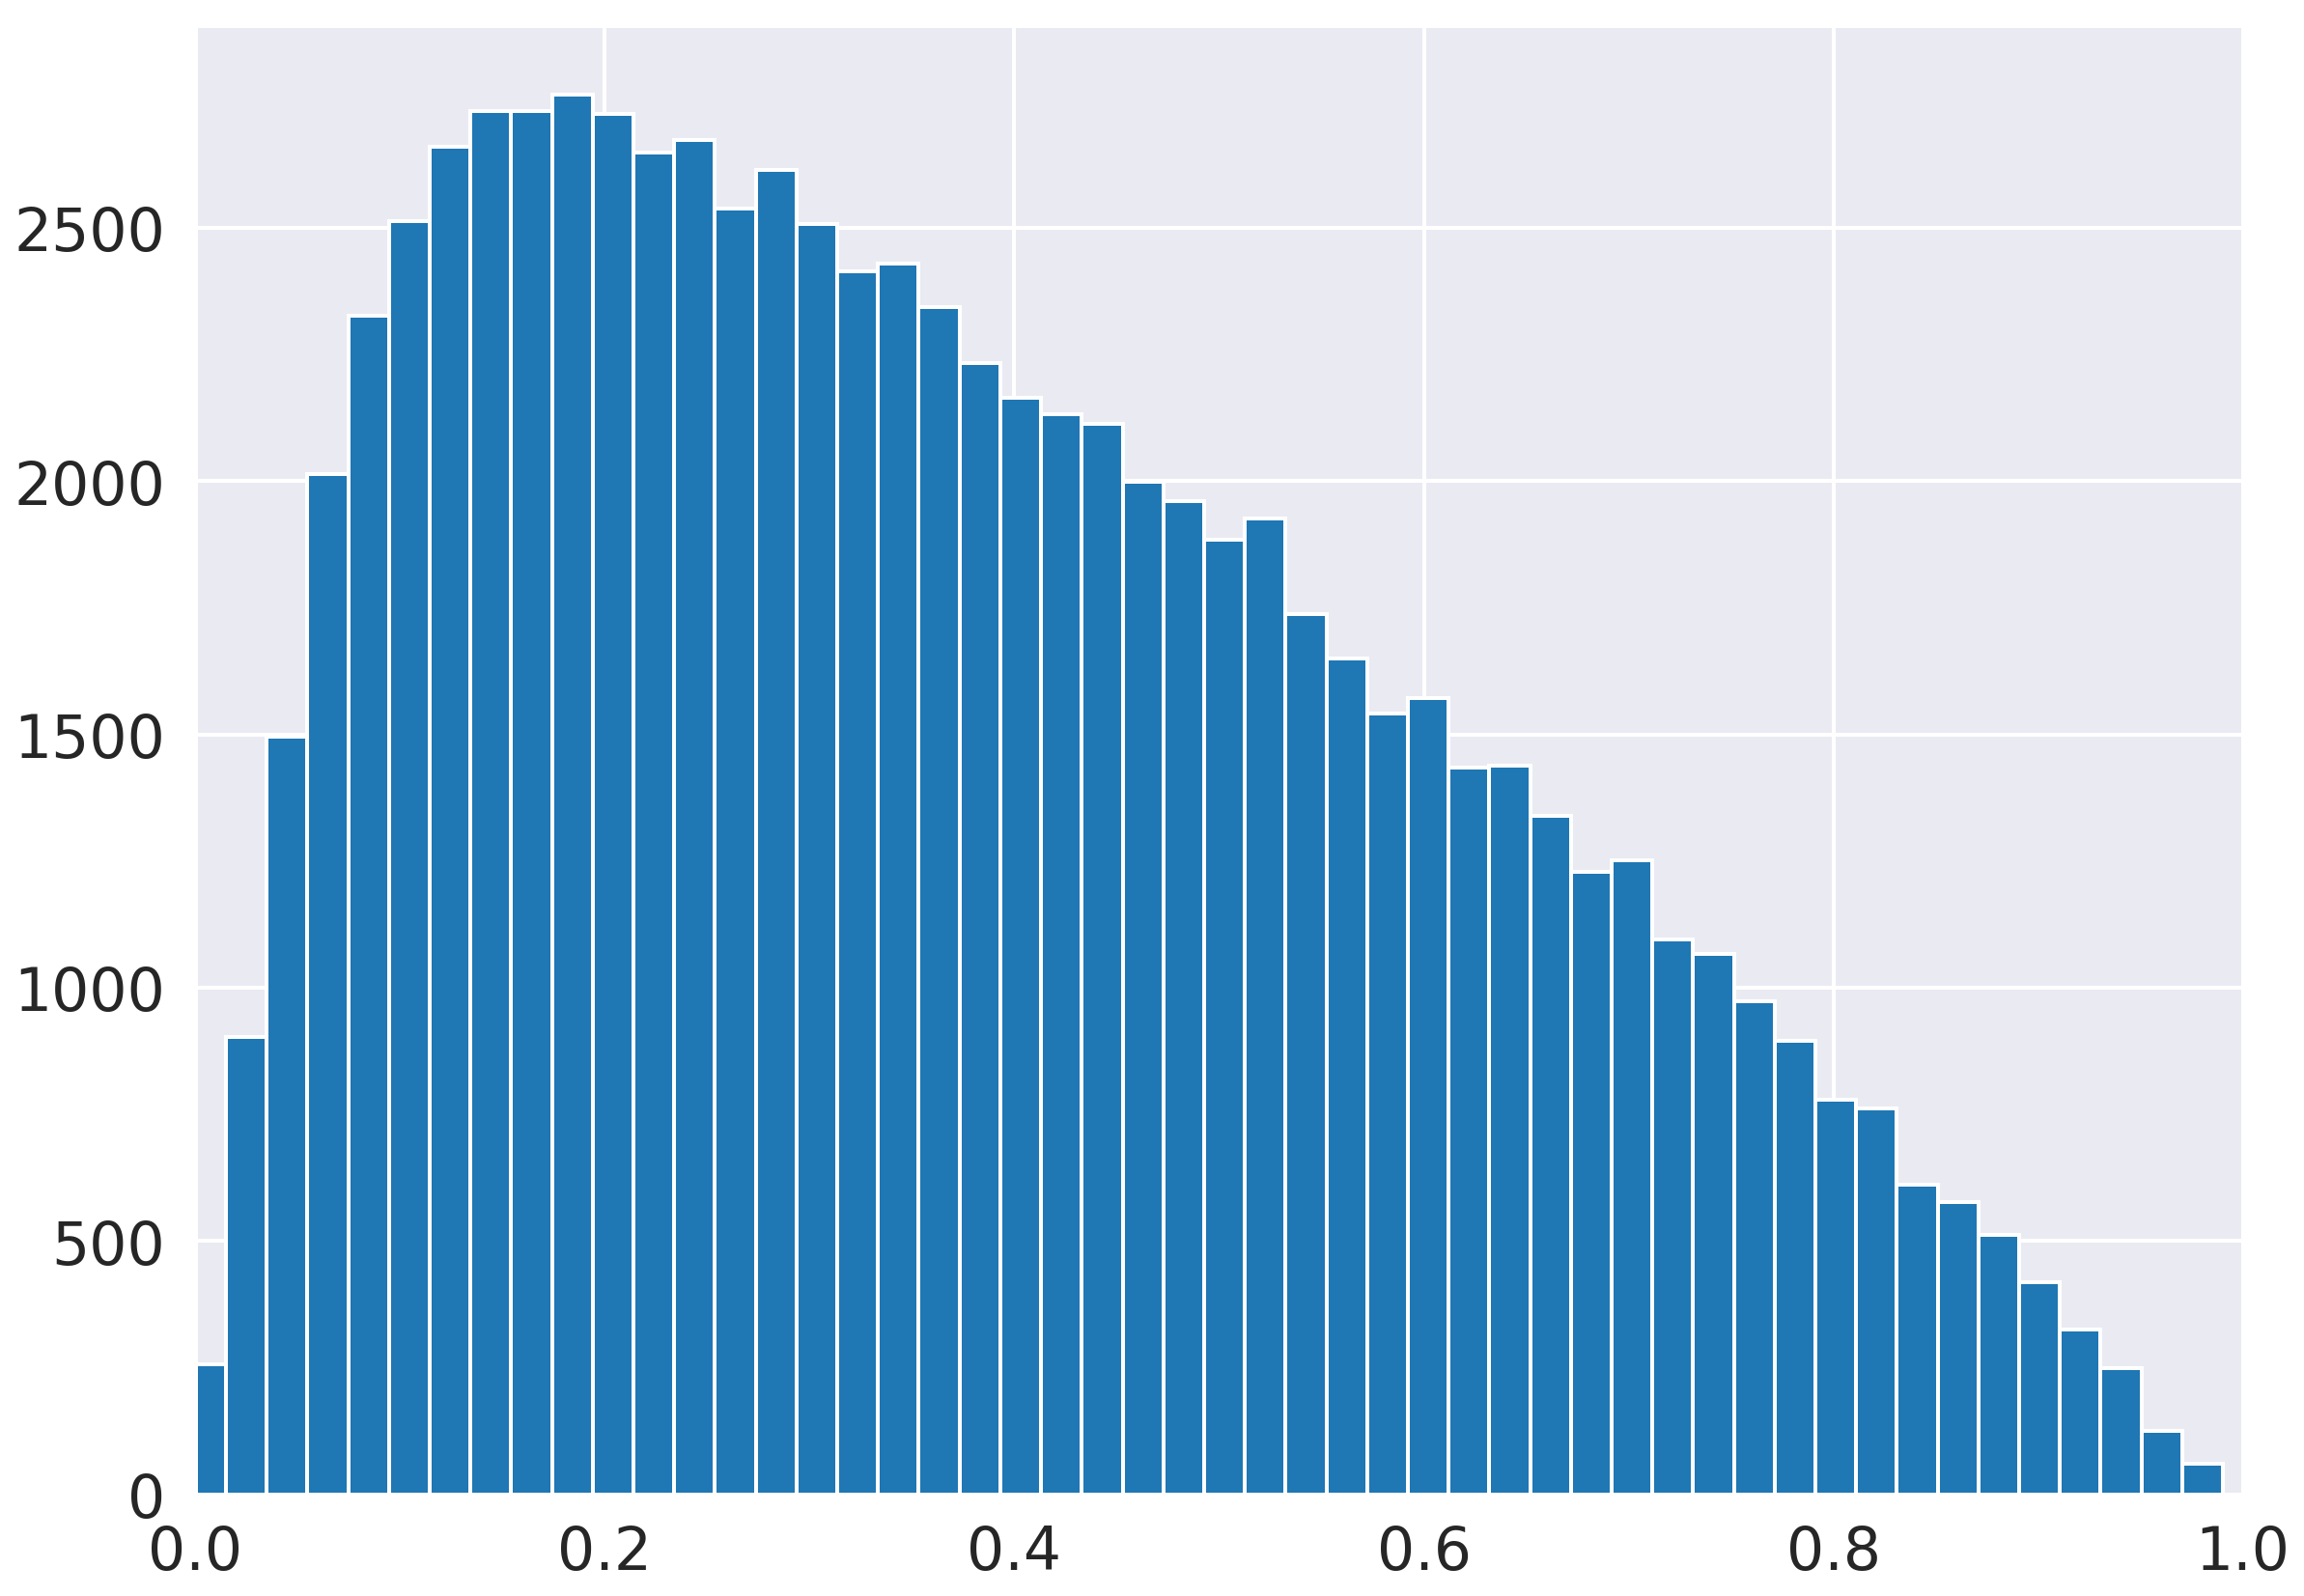

In [22]:
plt.hist(res, 100);
plt.xlim((0,1))

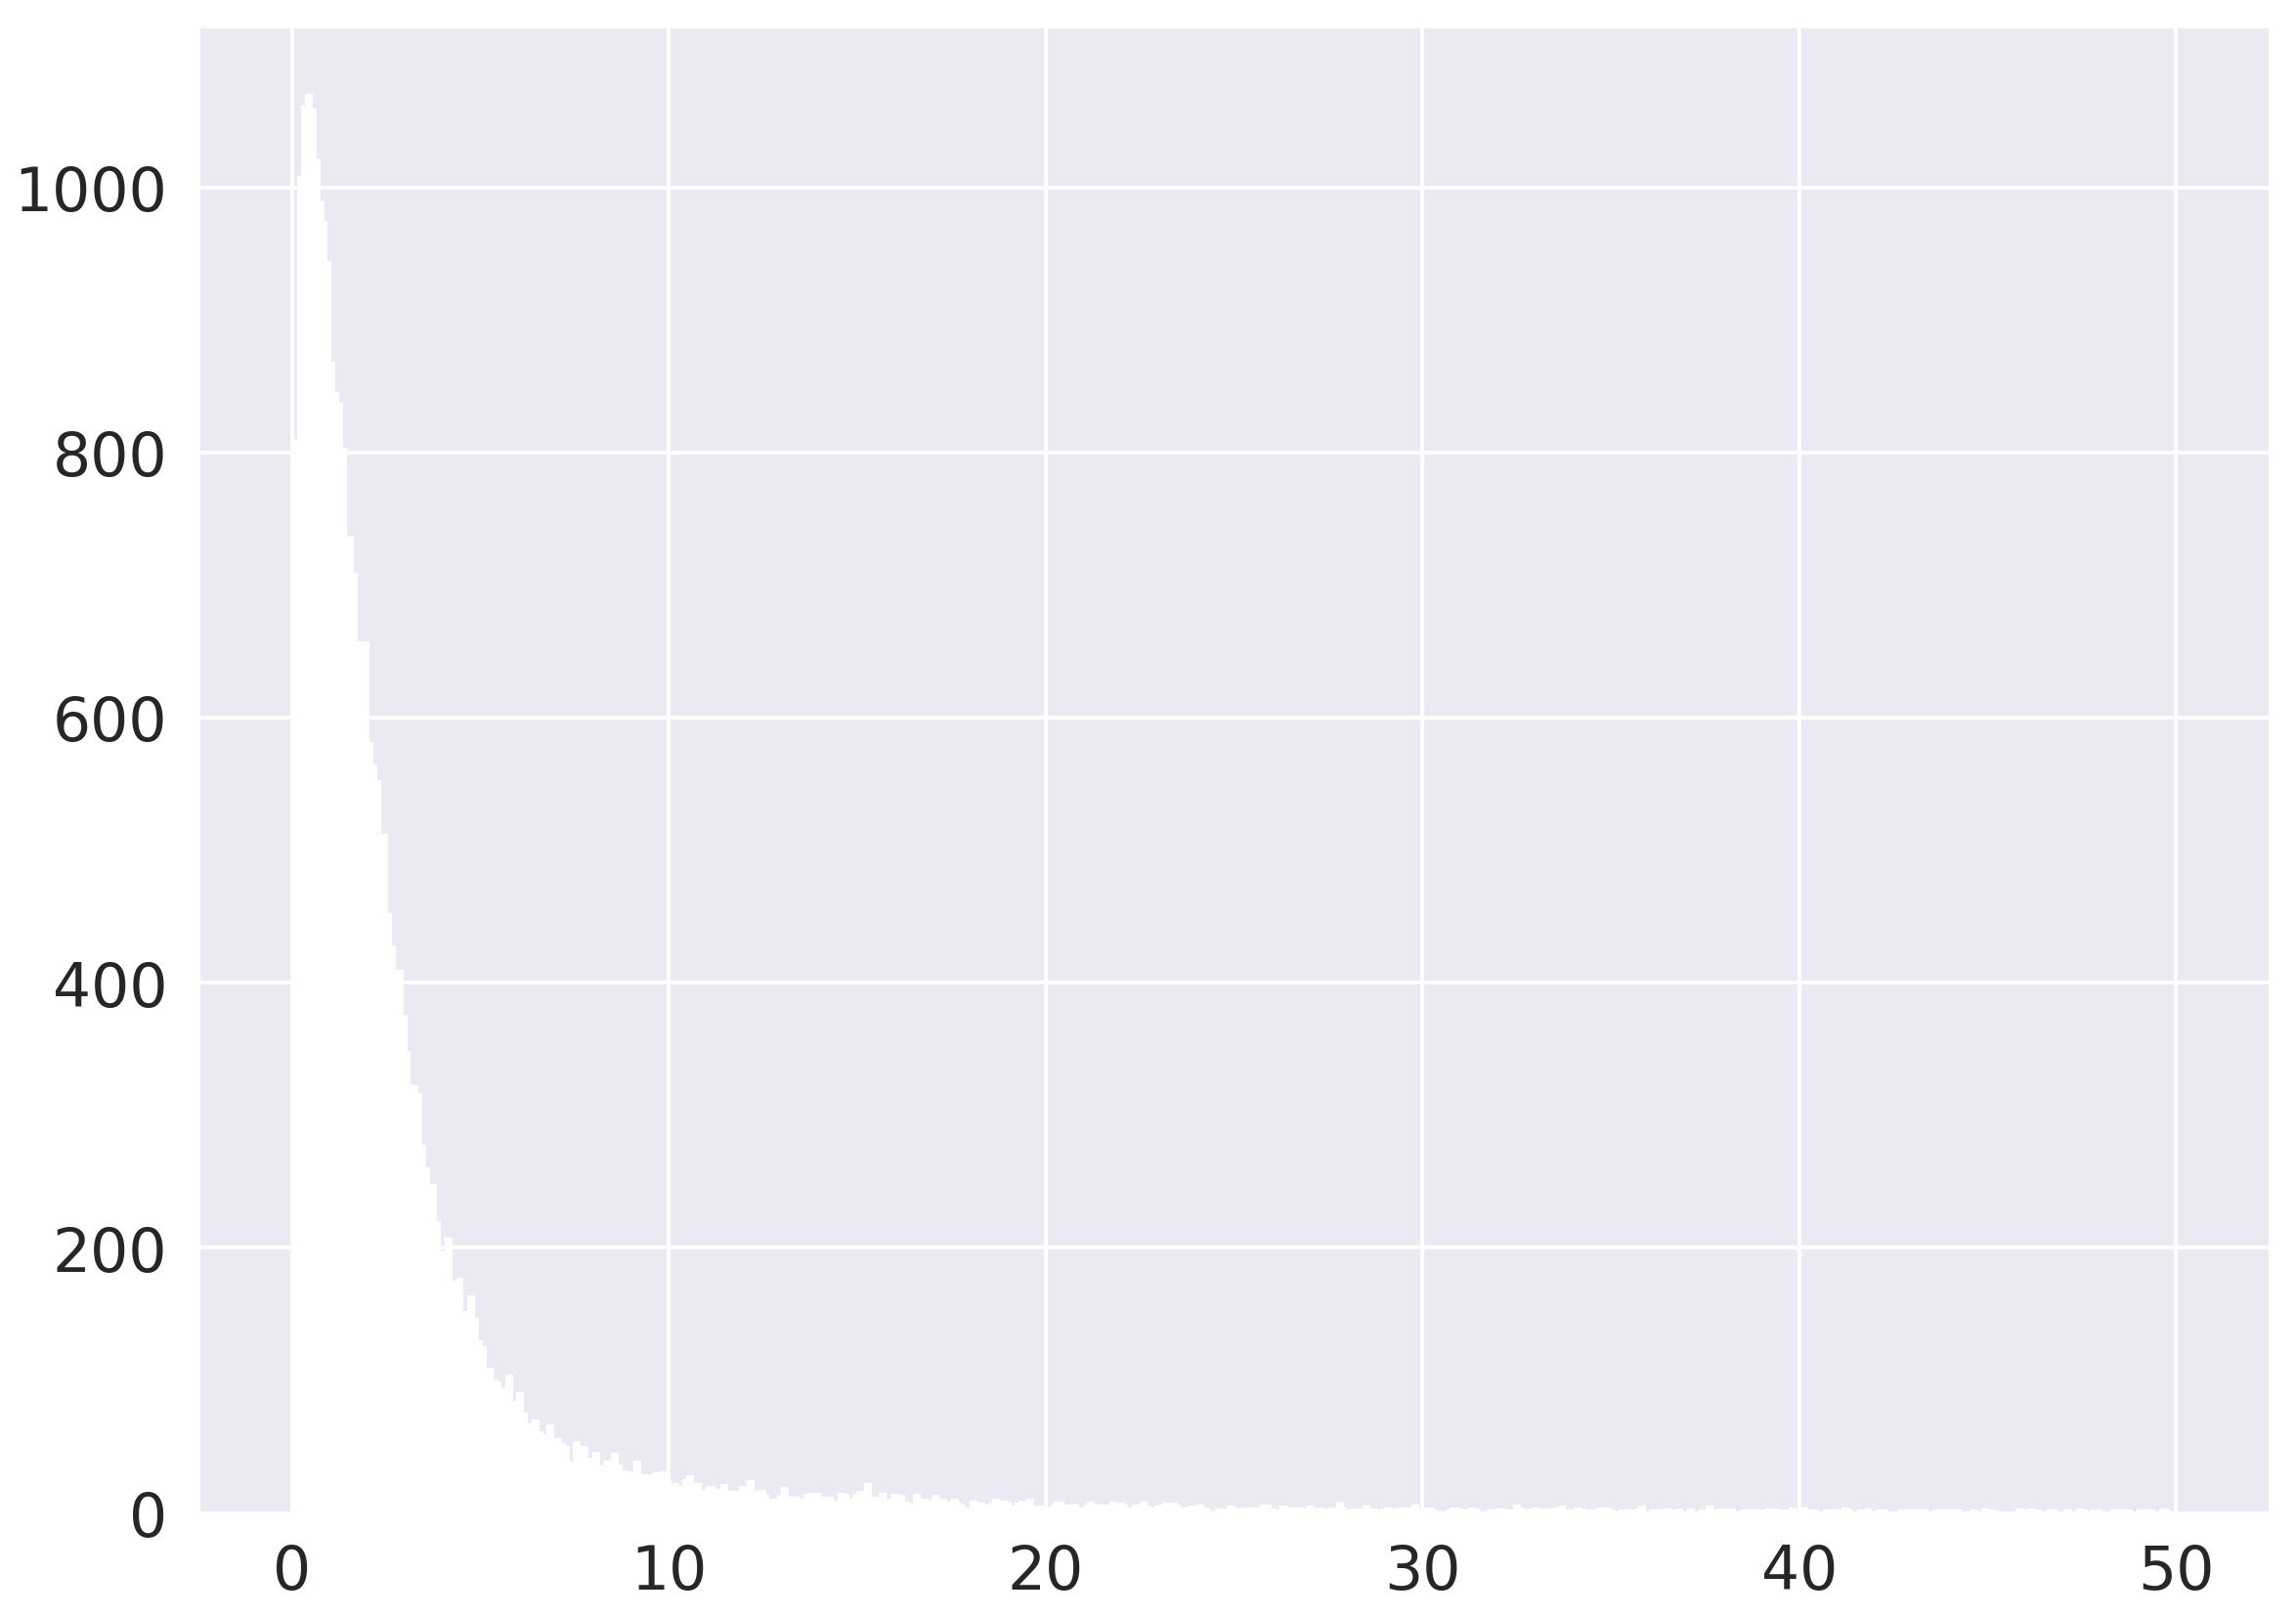

In [16]:
plt.hist(ratios, bins=np.linspace(0,50,500));

In [7]:
counts

34441

In [8]:
len(ratios)

30200

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0.0001, 1)

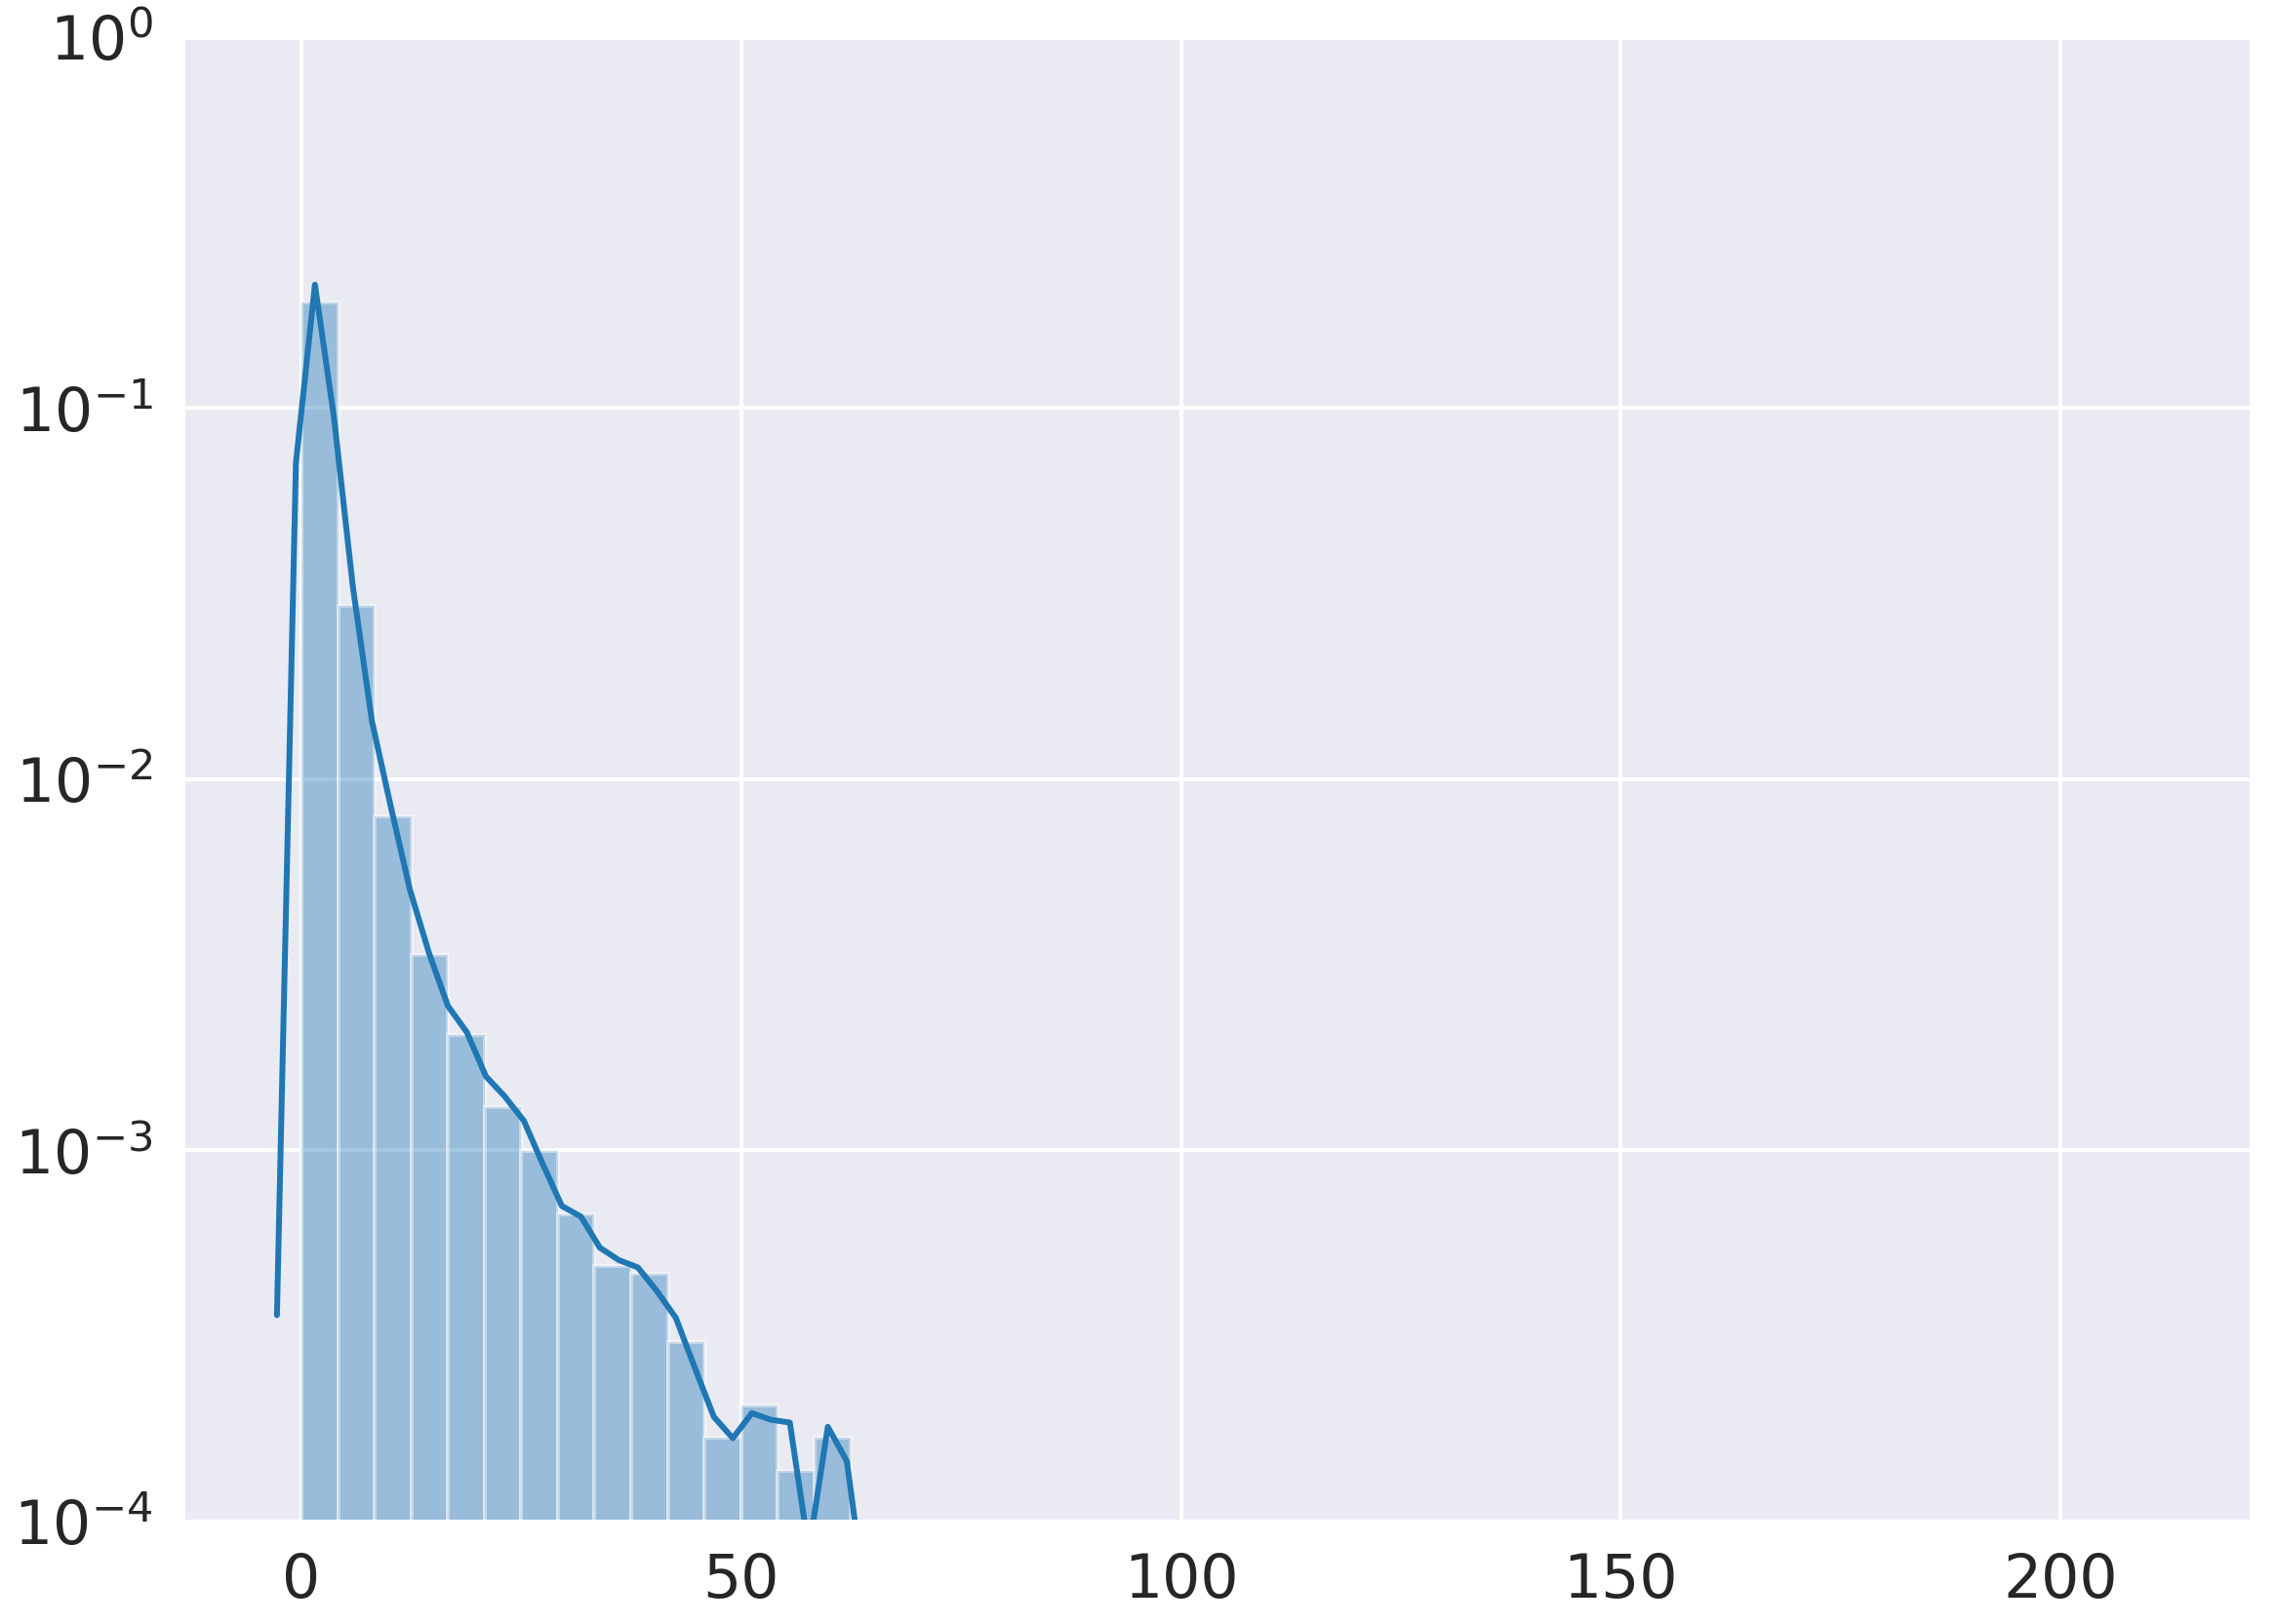

In [28]:
sns.distplot(ratios)
plt.yscale('log')
plt.ylim((0.0001,1))

In [33]:
means = [np.mean(np.random.choice(ratios, len(ratios), True)) for _ in range(10000)]    

In [34]:
np.mean(means)
np.std(means)

0.04161608474211449

In [35]:
np.mean(means)



3.573975440354734

In [36]:
np.std(means)**2

0.0017318985092628547

In [4]:
def resolution_factor(kol_profile, galaxy):
    
    pixel_scale = 0.03
    
    psf_img = kol_profile.drawImage(scale=pixel_scale)
    # psf_moments = gs.hsm.FindAdaptiveMom(psf_img)
    # psf_trace = 2 * (psf_moments.moments_sigma)**2
    
    convolved_obj = gs.Convolution(galaxy, kol_profile)
    convolved_img = convolved_obj.drawImage(scale=pixel_scale)
    # convolved_moments = gs.hsm.FindAdaptiveMom(convolved_img)
    # convolved_trace = 2 * (convolved_moments.moments_sigma)**2
    res = gs.hsm.EstimateShear(convolved_img, psf_img, strict='False')
    
    return res.resolution_factor
    
    # return 1 - (psf_trace/convolved_trace)

In [5]:
counts = 0
res = []
ratios = []
pixel_scale = 0.03
for idx in range(cat.getNObjects()):
    galaxy = cat.makeGalaxy(idx)
    try:
        fwhm = np.random.lognormal(mean=-0.5104, sigma=0.452) * 1.1
        kol_profile = gs.Kolmogorov(fwhm=fwhm)
        
        r2 = resolution_factor(kol_profile, galaxy)
        res.append(r2)
        if r2<0.3:
            raise ValueError('object unresolved')
        
        img = kol_profile.drawImage(scale=pixel_scale)
        psf_moments = gs.hsm.FindAdaptiveMom(img)
        psf_sigma = psf_moments.moments_sigma * pixel_scale
        psf_trace = 2 * psf_sigma**2


        img = galaxy.drawImage(scale=pixel_scale)
        moments = gs.hsm.FindAdaptiveMom(img)
        sigma = moments.moments_sigma * pixel_scale
        trace = 2 * sigma**2

        
        ratios.append(psf_trace/trace)
    except RuntimeError:
        pass
    except ValueError:
        counts += 1
        pass

In [27]:
np.mean(psf_sigmas)*pixel_scale

0.32743942725181585